# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import make_pipeline,Pipeline
import numpy as np 
import math
import scipy
import sklearn
from scipy import stats
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Loading the Data

In [ ]:
from google.colab import drive
#mount google drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Training Data

In [ ]:
training = pd.read_csv('/content/drive/My Drive/i-wish-i-was-there/training.csv', index_col=0) # reading the data, translating it into a pandas dataframe
display(training.head()) # display the first 5 rows of the dataframe


,CNNs,CNNs.1,CNNs.2,CNNs.3,CNNs.4,CNNs.5,CNNs.6,CNNs.7,CNNs.8,CNNs.9,CNNs.10,CNNs.11,CNNs.12,CNNs.13,CNNs.14,CNNs.15,CNNs.16,CNNs.17,CNNs.18,CNNs.19,CNNs.20,CNNs.21,CNNs.22,CNNs.23,CNNs.24,CNNs.25,CNNs.26,CNNs.27,CNNs.28,CNNs.29,CNNs.30,CNNs.31,CNNs.32,CNNs.33,CNNs.34,CNNs.35,CNNs.36,CNNs.37,CNNs.38,CNNs.39,...,GIST.473,GIST.474,GIST.475,GIST.476,GIST.477,GIST.478,GIST.479,GIST.480,GIST.481,GIST.482,GIST.483,GIST.484,GIST.485,GIST.486,GIST.487,GIST.488,GIST.489,GIST.490,GIST.491,GIST.492,GIST.493,GIST.494,GIST.495,GIST.496,GIST.497,GIST.498,GIST.499,GIST.500,GIST.501,GIST.502,GIST.503,GIST.504,GIST.505,GIST.506,GIST.507,GIST.508,GIST.509,GIST.510,GIST.511,prediction
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2.40260,0.55496,0.00000,0.00000,0.00000,0.00000,0.33893,0.00000,1.3191,0.22121,0.00000,0.00000,0.00000,1.182200,0.00000,0.0000,0.00000,0.000000,0.0000,0.000000,0.00000,0.00000,0.00000,0.00000,0.574640,0.0000,0.000000,0.00000,0.0,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.0,...,0.026257,0.022237,0.035813,0.025761,0.026295,0.027581,0.015342,0.026628,0.013269,0.024359,0.018712,0.024926,0.021963,0.021773,0.023568,0.019834,0.014300,0.025260,0.019607,0.027114,0.026370,0.025588,0.013442,0.037338,0.044497,0.035463,0.029618,0.021774,0.035416,0.037913,0.025488,0.021384,0.026530,0.037562,0.033369,0.030079,0.057239,0.048746,0.037217,0
2,0.00000,0.90992,0.00000,0.00000,0.00000,0.55614,0.17685,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.000000,0.70426,0.0000,0.00000,0.000000,0.0000,0.047146,0.00000,0.55651,0.00000,0.00000,1.710600,1.1107,0.000000,0.00000,0.0,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,1.3409,0.23577,0.65543,0.34635,0.0,...,0.030806,0.028828,0.049244,0.008391,0.032814,0.021262,0.053216,0.045054,0.023659,0.016105,0.030475,0.031841,0.027860,0.039781,0.022238,0.010312,0.019339,0.015486,0.021439,0.010026,0.023999,0.017424,0.027451,0.040467,0.030169,0.035430,0.025522,0.010907,0.030225,0.037154,0.019238,0.010607,0.027920,0.024132,0.018205,0.013909,0.023270,0.027539,0.024225,0
3,0.00000,0.15810,0.00000,0.30995,0.00000,0.55401,0.14810,0.00000,0.8690,0.68585,0.26028,0.00000,0.16087,0.198750,0.00000,1.0874,0.65465,0.099921,0.0000,0.000000,0.28526,0.00000,0.55342,0.46603,0.000000,0.0000,0.003528,0.00000,0.0,0.49692,0.18403,0.0000,0.39905,0.59798,0.96267,0.0000,1.19440,0.16481,0.66010,0.0,...,0.031535,0.022017,0.012663,0.022578,0.028834,0.027053,0.014175,0.003631,0.016840,0.025665,0.005014,0.002510,0.018211,0.029064,0.006209,0.010019,0.016031,0.023201,0.007252,0.011563,0.037755,0.029861,0.005622,0.002741,0.019477,0.021964,0.004842,0.001397,0.013861,0.021931,0.005746,0.007854,0.020796,0.039895,0.006463,0.008838,0.042023,0.045477,0.006091,0
4,0.59358,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.69931,0.0000,0.89240,0.37683,1.22810,0.86470,0.045856,0.00000,0.0000,0.00000,0.587140,0.0000,0.000000,0.00000,0.24957,0.00000,0.00000,0.216290,0.0000,0.713450,0.42922,0.0,0.00000,0.87437,0.0000,0.30495,0.00000,0.00000,0.0000,0.00000,1.71300,0.00000,0.0,...,0.047665,0.050777,0.083101,0.067032,0.057620,0.049326,0.042877,0.032275,0.031641,0.031658,0.026700,0.037861,0.041324,0.021998,0.018935,0.056127,0.050249,0.047804,0.080956,0.053136,0.051407,0.039121,0.042495,0.037705,0.034538,0.045489,0.028306,0.057239,0.046565,0.019960,0.021584,0.047490,0.054562,0.070832,0.078561,0.042256,0.048848,0.037105,0.037641,1
5,0.23735,0.00000,0.73587,0.35587,0.43856,0.00000,0.24112,0.00000,0.0000,0.00000,0.45833,0.27384,0.97601,0.000000,0.21408,0.0000,0.71919,0.616810,1.0536,1.289900,0.34861,0.34225,0.00000,0.00000,0.063612,1.2808,0.263000,0.42312,0.0,0.00000,0.14492,1.0053,0.50708,0.00000,0.00000,0.0000,0.00000,0.74880,0.87239,0.0,...,0.035683,0.040531,0.035493,0.023656,0.024188,0.019805,0.039100,0.006821,0.006670,0.035505,0.035298,0.015639,0.048585,0.067922,0.035657,0.015600,0.038519,0.035251,0.018100,0.015398,0.023604,0.011847,0.015496,0.009357,0.009917,0.028758,0.033971,0

## Additional Training Data

In [ ]:
add_training= pd.read_csv('/content/drive/My Drive/i-wish-i-was-there/additional_training.csv', index_col=0)
display(add_training.head()) # this will be used to avoid overfitting, since the training data is small in contrast of the testing data.

,CNNs,CNNs.1,CNNs.2,CNNs.3,CNNs.4,CNNs.5,CNNs.6,CNNs.7,CNNs.8,CNNs.9,CNNs.10,CNNs.11,CNNs.12,CNNs.13,CNNs.14,CNNs.15,CNNs.16,CNNs.17,CNNs.18,CNNs.19,CNNs.20,CNNs.21,CNNs.22,CNNs.23,CNNs.24,CNNs.25,CNNs.26,CNNs.27,CNNs.28,CNNs.29,CNNs.30,CNNs.31,CNNs.32,CNNs.33,CNNs.34,CNNs.35,CNNs.36,CNNs.37,CNNs.38,CNNs.39,...,GIST.473,GIST.474,GIST.475,GIST.476,GIST.477,GIST.478,GIST.479,GIST.480,GIST.481,GIST.482,GIST.483,GIST.484,GIST.485,GIST.486,GIST.487,GIST.488,GIST.489,GIST.490,GIST.491,GIST.492,GIST.493,GIST.494,GIST.495,GIST.496,GIST.497,GIST.498,GIST.499,GIST.500,GIST.501,GIST.502,GIST.503,GIST.504,GIST.505,GIST.506,GIST.507,GIST.508,GIST.509,GIST.510,GIST.511,prediction
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
658,0.00000,NaN,0.41863,0.00000,0.00000,NaN,0.12438,NaN,0.000000,0.68888,NaN,0.0,0.71353,0.00000,0.000000,0.00000,0.0,NaN,0.00000,0.0,0.00000,NaN,NaN,0.00000,NaN,NaN,0.57015,0.00000,NaN,0.00000,1.35230,0.00000,0.84572,NaN,0.00000,NaN,0.00000,1.316000,0.44880,0.24464,...,0.035700,0.033757,0.031359,0.059247,0.028116,0.044654,0.051071,NaN,0.046216,0.038831,NaN,0.037963,0.030655,NaN,0.009499,0.032448,NaN,NaN,0.028928,0.034068,0.037195,0.034413,0.079324,0.059083,0.048781,0.054679,0.025365,0.047336,0.035528,0.028680,NaN,0.087799,0.061104,NaN,0.028010,0.051542,0.057333,NaN,0.044703,1
659,0.27222,NaN,0.00000,0.93038,NaN,0.158220,0.29652,0.19514,0.356350,0.21324,0.00000,NaN,0.29368,0.35764,0.150550,0.82513,0.0,0.0000,0.00000,0.0,0.20489,NaN,NaN,NaN,0.095959,0.43119,0.22146,0.87171,1.0597,0.20487,0.77554,0.00000,0.48946,0.40433,1.04040,0.00000,0.15814,NaN,0.45721,0.32999,...,0.030537,0.036549,0.023467,0.009264,0.028296,0.043426,0.021837,0.020836,0.034026,0.029781,0.027791,0.013536,0.031982,0.026266,0.018281,0.011811,0.036143,0.025352,NaN,0.005332,0.023537,0.031165,0.018000,NaN,NaN,0.038609,0.037750,NaN,0.044788,0.040338,0.020110,0.010861,0.024534,0.040640,NaN,0.008024,0.028368,0.029981,NaN,0
660,0.00000,0.00000,0.00000,0.00000,NaN,NaN,0.00000,NaN,0.000000,1.07600,0.00000,0.0,0.00000,0.00000,0.000000,0.00000,0.0,NaN,0.00000,NaN,0.00000,0.00000,0.0,0.00000,0.000000,NaN,0.00000,0.00000,0.0000,0.00000,0.39440,0.00000,0.00000,1.08680,0.00000,0.00000,0.00000,0.060293,0.00000,NaN,...,0.034388,0.110440,0.049893,0.013368,0.038908,0.117030,NaN,0.023124,0.016796,0.024777,NaN,0.018898,0.015576,0.027476,0.060586,0.016207,0.018905,0.034271,0.045857,0.011654,0.026197,0.066750,0.052484,0.023777,0.019527,0.026790,0.033263,0.020991,0.031885,0.044624,0.067460,0.015855,0.018296,0.031740,0.028493,0.015583,NaN,NaN,NaN,0
661,0.00000,0.82940,0.00000,0.19344,0.00000,0.032355,NaN,0.00000,0.000000,0.00000,NaN,NaN,1.36130,0.00000,0.000000,0.00000,0.0,NaN,0.43372,NaN,0.12214,0.83573,0.0,0.00000,0.127040,NaN,NaN,0.00000,0.0000,NaN,0.00000,0.00000,NaN,0.00000,0.17656,0.16395,0.00000,0.551520,0.00000,0.00000,...,0.036348,0.029316,0.034934,0.045452,0.028769,0.033891,0.032211,0.029590,0.026316,NaN,0.023857,0.023840,0.025854,0.020405,0.030424,0.026011,0.021430,0.020387,0.029892,0.038464,0.029906,0.032651,0.028507,NaN,0.033580,0.028450,0.023398,0.030599,0.037857,0.026378,NaN,0.052799,NaN,NaN,NaN,0.038504,0.023370,0.043654,NaN,1
662,0.00000,0.47187,0.00000,0.00000,0.11894,0.833820,0.46096,NaN,0.033822,0.38619,0.21665,NaN,0.00000,0.16379,0.012392,1.39500,NaN,0.7199,0.76991,0.0,0.00000,0.00000,0.0,0.23463,0.016028,0.25635,NaN,0.88457,NaN,0.28074,0.00000,0.60443,0.61369,0.28007,0.00000,0.58969,NaN,0.057092,0.26069,0.00000,...,0.015808,0.024818,0.019898,0.006164,NaN,0.025414,NaN,0.001561,0.010275,0.021210,NaN,0.001125,0.016428,0.050335,0.012882,0.001095,0.018589,0.024786,0.009992,0.001874,NaN,NaN,0.015531,0.003421,NaN,0.024309,0.013281,0.001570,0.027010,0.029435,0.009978,0.001321,0.027350,0.033939,NaN,NaN,0.014153,0.043224,0.014016,1


## Annotation Confidence 

In [ ]:
confidence= pd.read_csv('/content/drive/My Drive/i-wish-i-was-there/annotation_confidence.csv', index_col=0)
display(confidence.head())  

,confidence
ID,
1,0.66
2,0.66
3,1.00
4,1.00
5,0.66


## Testing Data

In [ ]:
testing = pd.read_csv('/content/drive/My Drive/i-wish-i-was-there/testing.csv',index_col=0)
display(testing.head())

,CNNs,CNNs.1,CNNs.2,CNNs.3,CNNs.4,CNNs.5,CNNs.6,CNNs.7,CNNs.8,CNNs.9,CNNs.10,CNNs.11,CNNs.12,CNNs.13,CNNs.14,CNNs.15,CNNs.16,CNNs.17,CNNs.18,CNNs.19,CNNs.20,CNNs.21,CNNs.22,CNNs.23,CNNs.24,CNNs.25,CNNs.26,CNNs.27,CNNs.28,CNNs.29,CNNs.30,CNNs.31,CNNs.32,CNNs.33,CNNs.34,CNNs.35,CNNs.36,CNNs.37,CNNs.38,CNNs.39,...,GIST.472,GIST.473,GIST.474,GIST.475,GIST.476,GIST.477,GIST.478,GIST.479,GIST.480,GIST.481,GIST.482,GIST.483,GIST.484,GIST.485,GIST.486,GIST.487,GIST.488,GIST.489,GIST.490,GIST.491,GIST.492,GIST.493,GIST.494,GIST.495,GIST.496,GIST.497,GIST.498,GIST.499,GIST.500,GIST.501,GIST.502,GIST.503,GIST.504,GIST.505,GIST.506,GIST.507,GIST.508,GIST.509,GIST.510,GIST.511
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0000,0.00000,0.0000,0.75877,0.0,0.96192,0.0000,0.00000,1.4687,0.00000,0.00000,0.00000,0.00000,1.0713,0.00000,0.00000,0.000000,0.0000,0.000000,0.0,2.5652,0.00000,0.00000,0.0,0.00000,0.0,0.00000,0.64541,0.0,0.00000,0.00000,0.00000,1.8378,0.00000,...,0.044285,0.053786,0.046604,0.030163,0.065479,0.094596,0.068552,0.040858,0.016034,0.047529,0.028239,0.023256,0.006061,0.036052,0.028640,0.008907,0.012366,0.041522,0.032790,0.006975,0.016121,0.048321,0.036664,0.009728,0.013215,0.053181,0.020583,0.031436,0.003628,0.049370,0.029087,0.014856,0.008578,0.067175,0.027362,0.007432,0.007648,0.054333,0.025815,0.012043
2,0.37858,0.0,0.0,0.0,0.0,0.00000,0.1369,0.00000,0.6918,0.14247,0.0,1.30800,1.2396,0.84935,0.0000,0.00000,0.04752,0.00000,0.00000,0.0000,0.10758,0.00000,0.053884,0.0000,0.000000,0.0,2.4657,0.00000,0.00000,0.0,0.58239,0.0,1.07300,0.22478,0.0,0.00000,0.00000,1.21980,0.0000,0.59855,...,0.029931,0.043737,0.064317,0.042764,0.046151,0.039685,0.030180,0.044499,0.034822,0.045036,0.035329,0.012042,0.044775,0.045340,0.055853,0.019137,0.017512,0.042870,0.065706,0.038566,0.029534,0.040313,0.030891,0.032992,0.056467,0.047358,0.028065,0.026726,0.051068,0.035405,0.034856,0.023554,0.054514,0.051730,0.030697,0.051644,0.050385,0.047501,0.040084,0.052093
3,0.00000,0.0,0.0,0.0,0.0,0.00000,1.3273,0.00000,0.0000,0.24238,0.0,0.00000,0.0000,0.00000,0.0000,0.30774,0.67734,0.00000,0.00000,0.0000,1.16450,0.77752,0.000000,1.8054,0.000000,0.0,0.0000,0.78831,0.47570,0.0,0.73393,0.0,0.62519,0.31958,0.0,0.25044,0.99058,0.00000,0.0000,0.00000,...,0.025619,0.023797,0.020000,0.017930,0.023976,0.030699,0.028096,0.013844,0.018119,0.019528,0.021907,0.014236,0.015713,0.016008,0.031801,0.027488,0.019247,0.017277,0.021710,0.016982,0.016002,0.020326,0.015942,0.011194,0.034646,0.024279,0.037311,0.018159,0.031568,0.026786,0.037900,0.026738,0.036373,0.025566,0.030701,0.017613,0.040271,0.025716,0.019017,0.014863
4,0.00000,0.0,0.0,0.0,0.0,0.35895,0.0000,1.85120,0.0000,0.30305,0.0,0.00000,0.0000,1.54010,0.0000,0.00000,0.00000,0.22151,0.17144,0.0000,0.00000,3.47140,0.878010,0.0000,0.000000,0.0,0.6515,0.00000,0.00000,0.0,2.60260,0.0,0.68536,0.00000,0.0,0.00000,0.00000,0.50052,0.0000,0.00000,...,0.042868,0.038730,0.078049,0.061955,0.059958,0.027223,0.035450,0.050541,0.022474,0.043058,0.021234,0.020898,0.024315,0.044882,0.033808,0.035978,0.030623,0.053783,0.040408,0.032330,0.041183,0.019812,0.017433,0.023221,0.021720,0.030462,0.021879,0.014704,0.030061,0.042936,0.035611,0.037939,0.023809,0.075968,0.041354,0.019115,0.029852,0.029376,0.023477,0.017668
5,0.00000,0.0,0.0,0.0,0.0,0.00000,0.8376,0.83166,0.0000,0.00000,0.0,0.00000,0.0000,0.00000,0.0000,0.70587,0.00000,0.00000,0.00000,0.0000,0.21569,0.43590,0.000000,1.5962,0.010742,0.0,0.0000,1.06420,0.61295,0.0,0.74389,0.0,0.45829,0.00000,0.0,0.80332,1.30590,0.00000,0.0000,0.00000,...,0.058674,0.015484,0.021086,0.037551,0.069649,0.025478,0.028547,0.034373,0.021797,0.017264,0.025779,0.034514,0.043667,0.029326,0.016806,0.023093,0.049063,0.014622,0.016786,0.034324,0.053918,0.015348,0.018566,0.036474,0.032714,0.021211,0.013354,0.032987,0.054350,0.039788,0.031130,0.038812,0.047654,0.025143,0.018677,0.035321,0.042059,0.019911,0.012559,0.029918


## Test Proportion 

In [ ]:
test_proportions= pd.read_csv('/content/drive/My Drive/i-wish-i-was-there/test_proportions.csv', index_col=0)
display(test_proportions.head())

""
0.5569 class 1
0.4431 class 0


## Concatanating

In [ ]:
frames = [training, add_training, confidence] # making a list including the dataframe that will be merged
first_merge = pd.concat([frames[0],frames[1]],axis=0) # merging the training + additional training data
concat_df = pd.concat([first_merge,frames[2]],axis=1) # adding the prediction confidence of each label
#concat_df

,CNNs,CNNs.1,CNNs.2,CNNs.3,CNNs.4,CNNs.5,CNNs.6,CNNs.7,CNNs.8,CNNs.9,CNNs.10,CNNs.11,CNNs.12,CNNs.13,CNNs.14,CNNs.15,CNNs.16,CNNs.17,CNNs.18,CNNs.19,CNNs.20,CNNs.21,CNNs.22,CNNs.23,CNNs.24,CNNs.25,CNNs.26,CNNs.27,CNNs.28,CNNs.29,CNNs.30,CNNs.31,CNNs.32,CNNs.33,CNNs.34,CNNs.35,CNNs.36,CNNs.37,CNNs.38,CNNs.39,...,GIST.474,GIST.475,GIST.476,GIST.477,GIST.478,GIST.479,GIST.480,GIST.481,GIST.482,GIST.483,GIST.484,GIST.485,GIST.486,GIST.487,GIST.488,GIST.489,GIST.490,GIST.491,GIST.492,GIST.493,GIST.494,GIST.495,GIST.496,GIST.497,GIST.498,GIST.499,GIST.500,GIST.501,GIST.502,GIST.503,GIST.504,GIST.505,GIST.506,GIST.507,GIST.508,GIST.509,GIST.510,GIST.511,prediction,confidence
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2.402600,0.55496,0.00000,0.00000,0.00000,0.00000,0.33893,0.00000,1.31910,0.22121,0.00000,0.00000,0.00000,1.182200,0.00000,0.0000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.574640,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,...,0.022237,0.035813,0.025761,0.026295,0.027581,0.015342,0.026628,0.013269,0.024359,0.018712,0.024926,0.021963,0.021773,0.023568,0.019834,0.014300,0.025260,0.019607,0.027114,0.026370,0.025588,0.013442,0.037338,0.044497,0.035463,0.029618,0.021774,0.035416,0.037913,0.025488,0.021384,0.026530,0.037562,0.033369,0.030079,0.057239,0.048746,0.037217,0,0.66
2,0.000000,0.90992,0.00000,0.00000,0.00000,0.55614,0.17685,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.70426,0.0000,0.00000,0.000000,0.00000,0.047146,0.00000,0.55651,0.00000,0.00000,1.710600,1.11070,0.000000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,1.34090,0.23577,0.655430,0.34635,0.00000,...,0.028828,0.049244,0.008391,0.032814,0.021262,0.053216,0.045054,0.023659,0.016105,0.030475,0.031841,0.027860,0.039781,0.022238,0.010312,0.019339,0.015486,0.021439,0.010026,0.023999,0.017424,0.027451,0.040467,0.030169,0.035430,0.025522,0.010907,0.030225,0.037154,0.019238,0.010607,0.027920,0.024132,0.018205,0.013909,0.023270,0.027539,0.024225,0,0.66
3,0.000000,0.15810,0.00000,0.30995,0.00000,0.55401,0.14810,0.00000,0.86900,0.68585,0.26028,0.00000,0.16087,0.198750,0.00000,1.0874,0.65465,0.099921,0.00000,0.000000,0.28526,0.00000,0.55342,0.46603,0.000000,0.00000,0.003528,0.00000,0.00000,0.49692,0.18403,0.0000,0.39905,0.59798,0.96267,0.00000,1.19440,0.164810,0.66010,0.00000,...,0.022017,0.012663,0.022578,0.028834,0.027053,0.014175,0.003631,0.016840,0.025665,0.005014,0.002510,0.018211,0.029064,0.006209,0.010019,0.016031,0.023201,0.007252,0.011563,0.037755,0.029861,0.005622,0.002741,0.019477,0.021964,0.004842,0.001397,0.013861,0.021931,0.005746,0.007854,0.020796,0.039895,0.006463,0.008838,0.042023,0.045477,0.006091,0,1.00
4,0.593580,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.69931,0.00000,0.89240,0.37683,1.22810,0.86470,0.045856,0.00000,0.0000,0.00000,0.587140,0.00000,0.000000,0.00000,0.24957,0.00000,0.00000,0.216290,0.00000,0.713450,0.42922,0.00000,0.00000,0.87437,0.0000,0.30495,0.00000,0.00000,0.00000,0.00000,1.713000,0.00000,0.00000,...,0.050777,0.083101,0.067032,0.057620,0.049326,0.042877,0.032275,0.031641,0.031658,0.026700,0.037861,0.041324,0.021998,0.018935,0.056127,0.050249,0.047804,0.080956,0.053136,0.051407,0.039121,0.042495,0.037705,0.034538,0.045489,0.028306,0.057239,0.046565,0.019960,0.021584,0.047490,0.054562,0.070832,0.078561,0.042256,0.048848,0.037105,0.037641,1,1.00
5,0.237350,0.00000,0.73587,0.35587,0.43856,0.00000,0.24112,0.00000,0.00000,0.00000,0.45833,0.27384,0.97601,0.000000,0.21408,0.0000,0.71919,0.616810,1.05360,1.289900,0.34861,0.34225,0.00000,0.00000,0.063612,1.28080,0.263000,0.42312,0.00000,0.00000,0.14492,1.0053,0.50708,0.00000,0.00000,0.00000,0.00000,0.748800,0.87239,0.00000,...,0.040531,0.035493,0.023656,0.024188,0.019805,0.039100,0.006821,0.006670,0.035505,0.035298,0.015639,0.048585,0.067922,0.035657,0.015600,0.038519,0.035251,0.018100,0.015398,0.023604,0.011847

# Data Cleaning

In [ ]:
#print('Train columns with null values:\n', concat_df.isnull().sum())  # counting the NaN values of the Training Data
#print("-"*10)

# Filling the Missing Values

# We are gonna split the dataset as to get all the rows that predict 0 and all the rows that predict 1. Then for each column we are gonna calculate its mean value and fill the NaN values with its corresponding mean.

class0 = concat_df.loc[concat_df['prediction'] == 0] # create a new data frame containing only the rows where the 'prediction' score is 0 
#class0
class1 = concat_df.loc[concat_df['prediction'] == 1] # create a new data frame containing only the rows where the 'prediction' score is 1
#class1
newclass0 = class0.fillna(class0.mean()) # replacing the NaN values with their corresponding Mean value (for the one with label 0)
#newclass0
newclass1 = class1.fillna(class1.mean())  # replacing the NaN values with their corresponding Mean value (for the one with label 1)
#newclass1
frames2 = [newclass0,newclass1] # making a list including the dataframe that will be merged
merged = pd.concat([frames2[0],frames2[1]],axis=0) # merging the training + additional training data
#merged
#print('Train columns with null values:\n', merged.isnull().sum())  # checking if all the NaN values are now filled
#print("-"*10)
cleaned_data = merged.sort_index() # sorting the index
#cleaned_data

# All the dataset is now cleaned (i.e., no dublicate rows, rows full of zeros, rows with NaN values), 
# so it is time to move on the details of the dataset.

,CNNs,CNNs.1,CNNs.2,CNNs.3,CNNs.4,CNNs.5,CNNs.6,CNNs.7,CNNs.8,CNNs.9,CNNs.10,CNNs.11,CNNs.12,CNNs.13,CNNs.14,CNNs.15,CNNs.16,CNNs.17,CNNs.18,CNNs.19,CNNs.20,CNNs.21,CNNs.22,CNNs.23,CNNs.24,CNNs.25,CNNs.26,CNNs.27,CNNs.28,CNNs.29,CNNs.30,CNNs.31,CNNs.32,CNNs.33,CNNs.34,CNNs.35,CNNs.36,CNNs.37,CNNs.38,CNNs.39,...,GIST.474,GIST.475,GIST.476,GIST.477,GIST.478,GIST.479,GIST.480,GIST.481,GIST.482,GIST.483,GIST.484,GIST.485,GIST.486,GIST.487,GIST.488,GIST.489,GIST.490,GIST.491,GIST.492,GIST.493,GIST.494,GIST.495,GIST.496,GIST.497,GIST.498,GIST.499,GIST.500,GIST.501,GIST.502,GIST.503,GIST.504,GIST.505,GIST.506,GIST.507,GIST.508,GIST.509,GIST.510,GIST.511,prediction,confidence
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2.402600,0.55496,0.000000,0.000000,0.000000,0.000000,0.338930,0.000000,1.31910,0.221210,0.000000,0.00000,0.00000,1.182200,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.574640,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.022237,0.035813,0.025761,0.026295,0.027581,0.015342,0.026628,0.013269,0.024359,0.018712,0.024926,0.021963,0.021773,0.023568,0.019834,0.014300,0.025260,0.019607,0.027114,0.026370,0.025588,0.013442,0.037338,0.044497,0.035463,0.029618,0.021774,0.035416,0.037913,0.025488,0.021384,0.026530,0.037562,0.033369,0.030079,0.057239,0.048746,0.037217,0,0.66
2,0.000000,0.90992,0.000000,0.000000,0.000000,0.556140,0.176850,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.70426,0.000000,0.000000,0.000000,0.000000,0.047146,0.000000,0.556510,0.000000,0.000000,1.710600,1.11070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.340900,0.23577,0.655430,0.34635,0.000000,...,0.028828,0.049244,0.008391,0.032814,0.021262,0.053216,0.045054,0.023659,0.016105,0.030475,0.031841,0.027860,0.039781,0.022238,0.010312,0.019339,0.015486,0.021439,0.010026,0.023999,0.017424,0.027451,0.040467,0.030169,0.035430,0.025522,0.010907,0.030225,0.037154,0.019238,0.010607,0.027920,0.024132,0.018205,0.013909,0.023270,0.027539,0.024225,0,0.66
3,0.000000,0.15810,0.000000,0.309950,0.000000,0.554010,0.148100,0.000000,0.86900,0.685850,0.260280,0.00000,0.16087,0.198750,0.00000,1.087400,0.654650,0.099921,0.000000,0.000000,0.285260,0.000000,0.553420,0.466030,0.000000,0.00000,0.003528,0.000000,0.000000,0.496920,0.184030,0.000000,0.399050,0.597980,0.96267,0.000000,1.19440,0.164810,0.66010,0.000000,...,0.022017,0.012663,0.022578,0.028834,0.027053,0.014175,0.003631,0.016840,0.025665,0.005014,0.002510,0.018211,0.029064,0.006209,0.010019,0.016031,0.023201,0.007252,0.011563,0.037755,0.029861,0.005622,0.002741,0.019477,0.021964,0.004842,0.001397,0.013861,0.021931,0.005746,0.007854,0.020796,0.039895,0.006463,0.008838,0.042023,0.045477,0.006091,0,1.00
4,0.593580,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.699310,0.00000,0.892400,0.376830,1.22810,0.86470,0.045856,0.00000,0.000000,0.000000,0.587140,0.000000,0.000000,0.000000,0.249570,0.000000,0.000000,0.216290,0.00000,0.713450,0.429220,0.000000,0.000000,0.874370,0.000000,0.304950,0.000000,0.00000,0.000000,0.00000,1.713000,0.00000,0.000000,...,0.050777,0.083101,0.067032,0.057620,0.049326,0.042877,0.032275,0.031641,0.031658,0.026700,0.037861,0.041324,0.021998,0.018935,0.056127,0.050249,0.047804,0.080956,0.053136,0.051407,0.039121,0.042495,0.037705,0.034538,0.045489,0.028306,0.057239,0.046565,0.019960,0.021584,0.047490,0.054562,0.070832,0.078561,0.042256,0.048848,0.037105,0.037641,1,1.00
5,0.237350,0.00000,0.735870,0.355870,0.438560,0.000000,0.241120,0.000000,0.00000,0.000000,0.458330,0.27384,0.97601,0.000000,0.21408,0.000000,0.719190,0.616810,1.053600,1.289900,0.348610,0.342250,0.000000,0.000000,0.063612,1.28080,0.263000,0.423120,0.000000,0.000000,0.144920,1.005300,0.507080,0.000000,0.00000,0.000000,0.00000,0.748800,0.87239,0.000000,...,0.040531,0.035493,0.023656,0.024188,0.019805,0.039100,0.00

# Exploratory Data Analysis 

In [ ]:
# In this section, we look further on the details of the dataset, 
# we investigate which type of scalar/ feature selection (i.e., dimensionality reduction)/ model selection
# is the most effective in our dataset. 
# First we are check the balance of our dataset.

print(cleaned_data['prediction'].value_counts()) # checking the balance of the dataset
display(test_proportions.head()) # test labels proportion 



0    3538
1    3028
Name: prediction, dtype: int64


""
0.5569 class 1
0.4431 class 0


##  Data Augmentation

In [ ]:
# In order to do the investigation of what I mentioned above I will create a Pipeline. The Pipeline
# will implement all the processes step by step. 
# The Scalars that will be investigated are the following:  StandardScaler, MaxAbsScaler, and L2 Normalization.
# The Feature Selection method that will be used are the following : SelectKBest(k=¬len(features)/2)
# The first step of the Pipeline is to do the data augmentation (oversampling).
# Then it will choose a scaling method, afterwards will perform dimensionality reduction and finally it will move on 
# to the model fit.
# The metric that will be used is roc_auc_score.
# Hence after looking at the results we will know the optimum values of the hyperparameters, and the model that gives the best score will be evaluated to the testing dataset.
features = cleaned_data.drop(['prediction','confidence'],axis=1)
labels = concat_df.loc[:,['prediction']] # column recording the labels 
arr_feat= np.array(features) # need to transform it into a numpy array 
arr_lab  = labels.values.ravel() # need to be reshaped into nx1

## Model Selection

### General Hyperparameters

In [ ]:
########################################### General Hyperparameters ###############################################
scalers_to_test = [StandardScaler(),MaxAbsScaler(),Normalizer()] # List of Scaling Methods

#Dimensionality Reduction hyper
SelectKBest(score_func=f_classif, k=2400) # Feature Selection Method, will return the best k values using f_classif metric witch is one of the most popular for binary classification tasks.
# k selected as n_features/2


SelectKBest(k=2400, score_func=<function f_classif at 0x7fc4ab88dcb0>)

In [ ]:
import numpy as np
np.logspace(-4,-1,4)

array([0.0001, 0.001 , 0.01  , 0.1   ])

### Specific Hyperparameters

In [ ]:
# SVC hyper

#kernel
kernel_to_test=['rbf'] # most popular kernel for SVM 

#gamma
gamma_to_test = np.logspace(-5,-3,3) # gamma will be log scaled values but smaller than C

#C
C_to_test = np.logspace(-4,-1,4) # C will be log scaled values 


In [ ]:

# Now that all the testing hyperparameters have been set it is time to create the pipeline.
# The order will be the following: Data Preparation->Scaling->Feature Selection->Classifier
# Pipeline will help me from any type of Data Leakage, since it will do any Data Preparation only to the training dataset.

pipe =  Pipeline([('over',SMOTE()),
        ('scaler', StandardScaler()),
        ('reduce_dim', SelectKBest(score_func=f_classif, k=2400)),
        ('clf', SVC())])


param_grid = [       
                         
        {'scaler': scalers_to_test,
         'clf__C': C_to_test,
         'clf__gamma':gamma_to_test,
         'clf__kernel':kernel_to_test}]
 
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=1, verbose=2, scoring='roc_auc',return_train_score=True)
grid.fit(arr_feat, arr_lab)
#print(grid.cv_results_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.6min
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.6min
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.6min
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.6min
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.6min
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.6min
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.6min
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.6min
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.6min
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.6min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.0001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.6min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.6min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.4min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.4min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.4min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.4min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.4min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.01, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.2min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.3min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.2min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.3min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.2min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=1e-05, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 1.9min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 1.9min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 1.9min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.0min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 1.9min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.6min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.6min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.6min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.6min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.5min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.0001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.3min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.3min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.3min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.3min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total= 2.3min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.2min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.2min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.2min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.2min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=MaxAbsScaler(copy=True), total= 2.2min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.5min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.6min
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2') 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, scaler=Normalizer(copy=True, norm='l2'), total= 2.6min


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 673.3min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


{'mean_fit_time': array([135.76563396, 135.23377213, 131.97484145, 131.86179652,
       132.93340616, 132.08376184, 132.33876009, 130.61156592,
       130.82215152, 130.675142  , 130.46551423, 131.44200902,
       130.87586527, 130.47310452, 131.23238268, 132.14507813,
       131.63717937, 131.5033915 , 133.22788191, 133.18645802,
       132.65147595, 127.52937884, 132.32354922, 132.04201393,
       131.90371857, 131.80949574, 131.22147326, 118.6269032 ,
       130.8662673 , 131.6031549 , 103.79807463, 133.63230777,
       131.9108273 , 120.05320296, 117.55436263, 133.37848902]), 'std_fit_time': array([0.30055127, 1.31333371, 0.32040411, 0.27138303, 0.70222683,
       0.19860008, 0.20869334, 0.26788835, 0.17728708, 0.17925918,
       0.41534648, 0.64596018, 0.29081251, 0.29626215, 0.70162554,
       0.26788704, 0.3774254 , 0.41340482, 0.22562936, 0.32970119,
       0.55060755, 0.62215089, 0.43896171, 0.65924003, 0.46114818,
       0.84433849, 0.55594194, 0.44300223, 0.2441974 , 0.45475

In [ ]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_)) # Returns the best score and the best hyperparameters.
means = grid.cv_results_['mean_test_score'] # column that records the mean test scores. 
stds = grid.cv_results_['std_test_score']  # column that records the std test scores.
params = grid.cv_results_['params'] # column that records the parameters used. 
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param)) # return the mean, std , param values for each case that was investigated.

Best: 0.851283 using {'clf__C': 0.1, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
0.837652 (0.015608) with: {'clf__C': 0.0001, 'clf__gamma': 1e-05, 'clf__kernel': 'rbf', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
0.837844 (0.015517) with: {'clf__C': 0.0001, 'clf__gamma': 1e-05, 'clf__kernel': 'rbf', 'scaler': MaxAbsScaler(copy=True)}
0.831290 (0.016982) with: {'clf__C': 0.0001, 'clf__gamma': 1e-05, 'clf__kernel': 'rbf', 'scaler': Normalizer(copy=True, norm='l2')}
0.838787 (0.014808) with: {'clf__C': 0.0001, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
0.837843 (0.015308) with: {'clf__C': 0.0001, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'scaler': MaxAbsScaler(copy=True)}
0.831573 (0.017069) with: {'clf__C': 0.0001, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'scaler': Normalizer(copy=True, norm='l2')}
0.819592 (0.010139) with: 

# Data Visualization

In [ ]:
data = pd.DataFrame(grid.cv_results_) # convert the results into a dataframe
data.index.name = 'slice' # index name 
cropped = data[['mean_test_score', 'std_test_score','param_clf__C','param_clf__gamma','param_scaler','mean_train_score']] #obtaining only the columns that I am interested for the visualization later.
ind_list1 = np.arange(0,34,3) # slicing the rows that are related to the standardscaled values
StandardValues = cropped.iloc[ind_list1]
ind_list2 = np.arange(1,35,3) # slicing the rows that are related to the maxabscaled values
AbsValues = cropped.iloc[ind_list2]
ind_list3 = np.arange(2,36,3) # # slicing the rows that are related to the normalized values
NormalValues = cropped.iloc[ind_list3]

In [ ]:
# function which will give the average score vs the hyperparameter values
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score'] # will take the column related to the mean test scores
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1)) # reshape to fit the dimension(4,3)

    scores_sd = cv_results['std_test_score'] # will take the column related to the mean std scores
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=8)
    ax.grid('on')

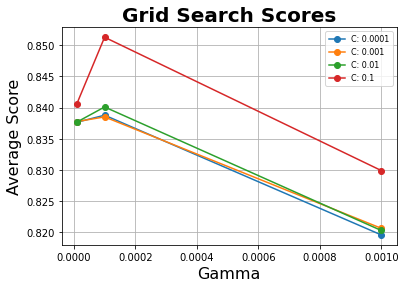

In [ ]:
# Plot of the StandardScaled values
plot_grid_search(StandardValues, gamma_to_test, C_to_test, 'Gamma', 'C')

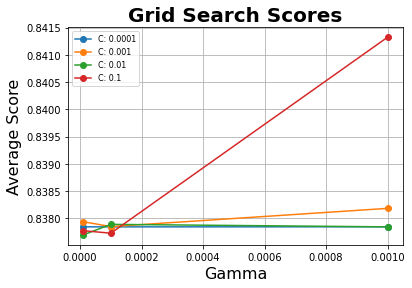

In [ ]:
# Plot of the MaxAbsScaled values
plot_grid_search(AbsValues, gamma_to_test, C_to_test, 'Gamma', 'C')

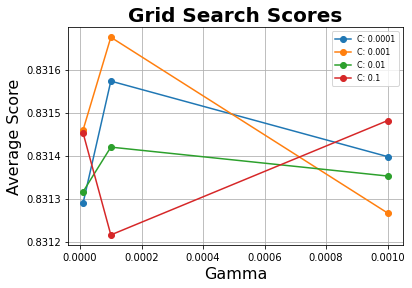

In [ ]:
# Plot of the Normalized values
plot_grid_search(NormalValues, gamma_to_test, C_to_test, 'Gamma', 'C')

# Model Architecture


In [ ]:
# Now that the investigation is done we are gonna use (grid.best_score_, grid.best_params_) to train the 
# entire training dataset.

oversample = SMOTE() 
balanced_feat,balanced_lab = oversample.fit_resample(arr_feat, arr_lab) #perform oversampling to the entire training dataset.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
Standardize = StandardScaler()
scaled_training = Standardize.fit_transform(balanced_feat) # fitting and transforming the best scaling method to the entire training dataset.
scaled_testing = Standardize.transform(testing) # we transform the testing dataset based on the fittin that was done to the training dataset.
Reduction = SelectKBest(score_func=f_classif, k=2400) # in the next lines we do the same for the feature selection.
Reduced_training = Reduction.fit_transform(scaled_training,balanced_lab)
Reduced_testing = Reduction.transform(scaled_testing)

In [ ]:
clf = SVC(kernel='rbf',C=0.1,gamma=0.0001) # initialising the classifier, with the best hyperparameters.
clf.fit(Reduced_training,balanced_lab) # fitting the classifier to the scaled and dimensionality reduced dataset.
prediction = clf.predict(Reduced_testing) # predicting the unlabeled testing dataset.

In [ ]:
my_submission = pd.DataFrame(prediction.T,columns = ['prediction']) # creating one column dataframe recording the prediction.
my_submission.index += 1 # making index to start from 1, so it can fit to the sample submission.

In [ ]:
# checking the label proportions to see if they are similar with the given one
# to form an opinion of possible overfitting. #Class: 1 has to be occured slightly more than Class:0 
print(my_submission['prediction'].value_counts()) 

1    2894
0    1608
Name: prediction, dtype: int64


In [ ]:
my_submission.to_csv('/content/drive/My Drive/Colab Notebooks/SVM_RBF_tuned_2400.csv', index_label='ID') # converting the dataframe to csv so as to be in the correct form for the submission.